In [24]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt     
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

from scipy.stats import norm
from scipy.integrate import quad



In [25]:
#List of countries to be used in the analysis
countries = ['Austria (AT)', 'Belgium (BE)', 
       'Switzerland (CH)', 'Czech Republic (CZ)', 'DE-LU',
       'Estonia (EE)', 'Spain (ES)', 'Finland (FI)', 'France (FR)', 
       'Greece (GR)', 'Croatia (HR)', 'Hungary (HU)', 
       'IT-North','Lithuania (LT)', 'Netherlands (NL)', 
       'Poland (PL)', 'Portugal (PT)']
start_year = 2020 
end_year = 2024 
moths = [f'0{x}' if x < 10 else str(x) for x in range(1, 13)]
df_joined = pd.DataFrame()
#Loop through the countries and years to create a DataFrame with the desired structure     

for year in range(start_year, end_year+1):
 for month in moths:
       df = pd.read_csv(f'ENTSOE_DATA/{year}_{month}_EnergyPrices_12.1.D_r3.csv', sep='\t')
       df['DateTime(UTC)'] = pd.to_datetime(df['DateTime(UTC)'])
       df = df[df['Sequence'] !='2' ]
       df = df[df['DateTime(UTC)'].dt.strftime('%H:%M:%S') == '12:00:00']
       df = df[df['AreaDisplayName'].isin(countries)]
       df = df[['DateTime(UTC)', 'AreaDisplayName', 'Price[Currency/MWh]']]
       df_joined = pd.concat([df_joined, df], ignore_index=True)
df_joined

,DateTime(UTC),AreaDisplayName,Price[Currency/MWh]
0,2020-01-01 12:00:00,Austria (AT),30.04
1,2020-01-02 12:00:00,Austria (AT),44.90
2,2020-01-03 12:00:00,Austria (AT),42.97
3,2020-01-04 12:00:00,Austria (AT),40.00
4,2020-01-05 12:00:00,Austria (AT),35.37
...,...,...,...
31054,2024-12-27 12:00:00,Portugal (PT),107.94
31055,2024-12-28 12:00:00,Portugal (PT),110.01
31056,2024-12-29 12:00:00,Portugal (PT),108.88
31057,2024-12-30 12:00:00,Portugal (PT),116.02


<Axes: xlabel='AreaDisplayName'>

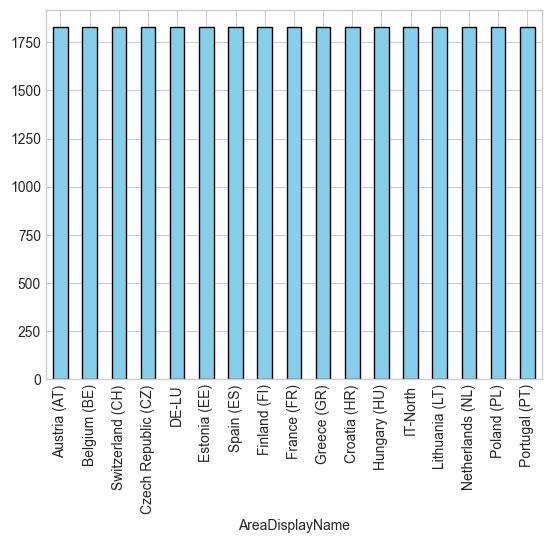

In [26]:
counts = df_joined['AreaDisplayName'].value_counts().sort_values(ascending=False)
counts.plot(kind='bar', color='skyblue', edgecolor='black')

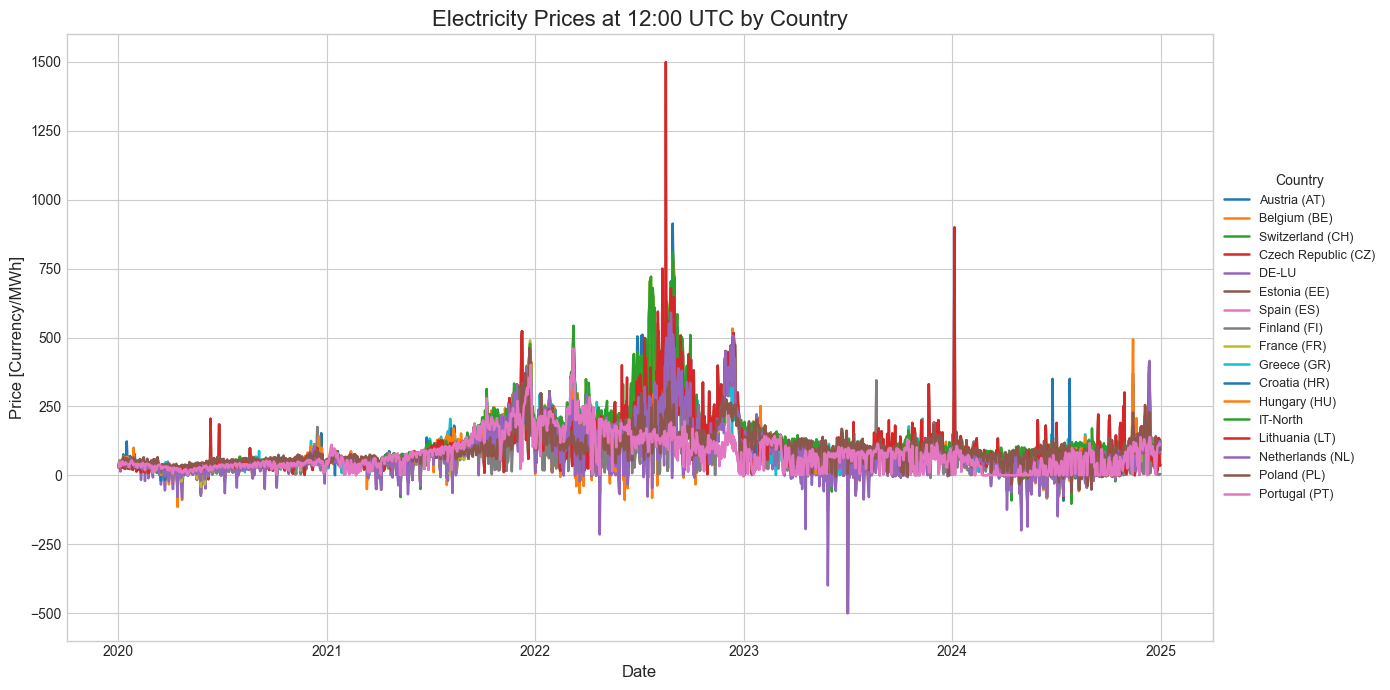

In [27]:
# Inizializza la figura
plt.figure(figsize=(14, 7))

# Loop su ogni paese e plottaggio della rispettiva curva
for country in countries:
    df_country = df_joined[df_joined['AreaDisplayName'] == country].copy()
    df_country.sort_values(by='DateTime(UTC)', inplace=True)

    # Plotta solo se ci sono dati per quella zona
    if not df_country.empty:
        plt.plot(df_country['DateTime(UTC)'], df_country['Price[Currency/MWh]'],
                 label=country, linewidth=1.8)

# Format dell'asse X per mostrare solo gli anni
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Titoli e assi
plt.title("Electricity Prices at 12:00 UTC by Country", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price [Currency/MWh]", fontsize=12)

# Legenda spostata a lato per chiarezza
plt.legend(title="Country", fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))

# Miglioramenti estetici
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
def log_yield(df, countries):
    df_yields = df.copy()
    df_yields['log_yields'] = np.nan  # crea la colonna output

    for country in countries:
        mask = df_yields['AreaDisplayName'] == country
        prices = df_yields.loc[mask, 'Price[Currency/MWh]'].copy()

        #handle incorrect number 
        prices = prices.apply(lambda x: x if x > 0 else 1)

        # Calcola il log-yield: log(P_t) - log(P_{t-1})
        log_y = (np.log(prices) - np.log(prices.shift(1)))*100

        # Inserisci il risultato nella colonna 'log_yields'
        df_yields.loc[mask, 'log_yields'] = log_y

    return df_yields


In [29]:
#generate log yields for each zone
df_log_yields = log_yield(df_joined, countries)
len(df_log_yields[df_log_yields['AreaDisplayName'] == 'Belgium (BE)'])

1827

In [30]:
#generate a plot for the log yields for each zone , with a KDE plot on the right
def plot_log_yields(df_yields, countries, title="Log-Yields Time Series & KDEs"):
    plt.style.use('seaborn-v0_8-whitegrid')  # estetica pulita

    fig = plt.figure(figsize=(16, 7))
    gs = GridSpec(1, 2, width_ratios=[6, 2])
    
    # === Left plot: Time Series ===
    ax0 = fig.add_subplot(gs[0])

    for country in countries:
        df_country = df_yields[df_yields['AreaDisplayName'] == country]
        ax0.plot(df_country['DateTime(UTC)'], df_country['log_yields'],
                 label=country, linewidth=1.8)

    ax0.set_title("Log-Yields Time Series by Country", fontsize=16)
    ax0.set_xlabel("Date", fontsize=12)
    ax0.set_ylabel("Log-Yield", fontsize=12)
    ax0.legend(title="Country", fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))

    ax0.xaxis.set_major_locator(mdates.YearLocator())
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # === Right plot: KDE Distributions ===
    ax1 = fig.add_subplot(gs[1])
    
    for country in countries:
        log_vals = df_yields[df_yields['AreaDisplayName'] == country]['log_yields'].dropna()
        sns.kdeplot(y=log_vals, ax=ax1, label=country, fill=True, linewidth=1.3)

    ax1.set_xlabel("Density")
    ax1.set_ylabel("Log-Yield")
    ax1.set_title("Log-Yield Distributions", fontsize=14)

    plt.tight_layout()
    plt.show()


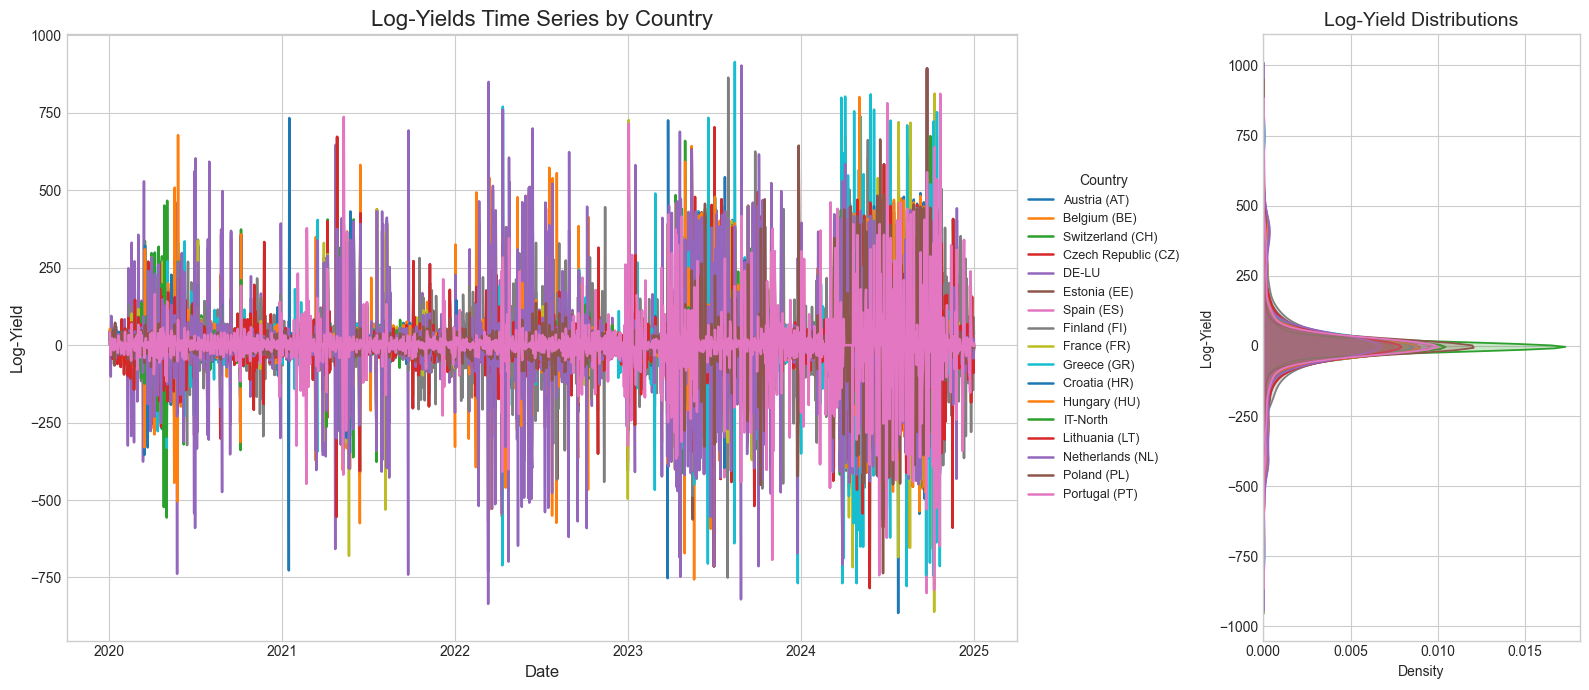

In [31]:
plot_log_yields(df_log_yields, countries)

In [32]:
# Calculate the Value at Risk (VaR) and Conditional Value at Risk (CVaR)
def var(losses,alpha=0.975):
    """
    Compute the Generalized Conditional Value at Risk (GCVaR).
    
    Parameters:
        losses (array-like): Vector of losses (higher = worse).
        alpha (float): Confidence level (e.g., 0.95).
        g (function): Distortion function g(u), where u in [0, 1].
        
    Returns:
        GCVaR (float): Generalized Conditional Value at Risk
    """
    losses = np.sort(losses)
    n = len(losses)
    u_vals = np.arange(1, n + 1) / n  # Empirical probabilities
 
    # Compute VaR at different u levels
    VaR_u = np.quantile(losses, u_vals, method='linear') 
  
    valid_idx = u_vals[1:] > alpha
    Var =[VaR_u[1:][valid_idx],u_vals[1:][valid_idx]]
 
    return Var[0][0]


In [33]:
losses = df_log_yields[df_log_yields['AreaDisplayName'] == countries[0]]['log_yields']  # Example losses (absolute values of returns)
# Calcolo GCVaR
result = var(losses,alpha = 0.99)
losses = losses.values
len(losses)


1827

In [34]:
# Extreme Downside Correlation (EDC)
def EDC_range(start_year, end_year, df, R1, R2,alpha=0.99, 
              start_month=1, start_day=1, 
              end_month=12, end_day=31):
    """
    Calculates the Extreme Downside Correlation (EDC) between two time series
    for a specified date range (by year, month, or day).

    Parameters:
    ---------------
    start_year (int): The starting year for the calculation.
    end_year (int): The ending year for the calculation (inclusive).
    df (DataFrame): The dataframe containing the time series data.
    R1 (str): The column name for the first time series.
    R2 (str): The column name for the second time series.
    start_month (int, optional): The starting month (default is 1 for January).
    start_day (int, optional): The starting day (default is 1).
    end_month (int, optional): The ending month (default is 12 for December).
    end_day (int, optional): The ending day (default is 31).
    Returns:
    --------
    float: The Extreme Downside Correlation value between R1 and R2 over the 
           specified time period. Returns np.nan if the denominator is zero.
    """
    
    df = df.copy()
    df = df.dropna()
    df["DateTime(UTC)"] = pd.to_datetime(df["DateTime(UTC)"])

    # Costruisci le date precise
    start_date = pd.Timestamp(start_year, start_month, start_day)
    end_date = pd.Timestamp(end_year, end_month, end_day)

    # Filtra per l'intervallo temporale
    df = df[(df["DateTime(UTC)"] >= start_date) & (df["DateTime(UTC)"] <= end_date)]

    #extract the values of the series 
    #df[df['AreaDisplayName'] == R1]['log_yields'].values
    R1_vals =  df[df['AreaDisplayName'] == R1]['log_yields'].values
    R2_vals =  df[df['AreaDisplayName'] == R2]['log_yields'].values

    
    # Calculate the mean of the two series
    R1_mean = np.mean(R1_vals)
    R2_mean = np.mean(R2_vals)
    
    # fixed cvar for the considered time period
    var_R1= var(R1_vals,alpha = alpha)
    var_R2 = var(R2_vals,alpha = alpha)
    
     
    bol_R1 = np.where(R1_vals > var_R1, 1, 0)
    bol_R2 = np.where(R2_vals > var_R2, 1, 0)
    
    numerator = np.sum((R1_vals - R1_mean) * bol_R1 * (R2_vals - R2_mean) * bol_R2)
    denominator = np.sqrt(np.sum(((R1_vals - R1_mean) * bol_R1)**2)) * np.sqrt(np.sum(((R2_vals - R2_mean) * bol_R2)**2))
 
    return numerator/ denominator if denominator != 0 else np.nan

In [35]:
EDC_range(2020, 2021, df_log_yields, countries[0], countries[1])

0.8656655191167808

In [36]:
def build_EDC_matrix_symmetric(df, zone_list, start_year, end_year, alpha=0.975,
                               start_day=1, start_month=1, end_day=31, end_month=12):
    """
    Builds a symmetric EDC matrix (zones x zones) for a given time window.

    Parameters:
    ------------
    df (DataFrame): Original DataFrame with 'date' and return columns.
    zone_list (list): List of column names for zones to include.
    start_year, end_year (int): Range of years for the analysis.
    alpha (float): Confidence level for CVaR (default=0.975).
    start_day/month, end_day/month: Day/month filter for each year.

    Returns:
    --------
    pd.DataFrame: Symmetric EDC matrix.
    """
    df = df.copy()
    df["DateTime(UTC)"] = pd.to_datetime(df["DateTime(UTC)"])

    # Filtro per data e zone
    mask = (
        (df["DateTime(UTC)"] >= pd.Timestamp(start_year, start_month, start_day)) &
        (df["DateTime(UTC)"] <= pd.Timestamp(end_year, end_month, end_day)) 
      
    )
    df_filtered = df.loc[mask, ["DateTime(UTC)","AreaDisplayName","log_yields"]]
    

    # Inizializzazione matrice vuota
    EDC_matrix = pd.DataFrame(index=zone_list, columns=zone_list, dtype=float)

    # Calcolo solo per i < j
    for i in range(len(zone_list)):
        for j in range(i, len(zone_list)):
            if i == j:
                EDC_matrix.iloc[i, j] = 1.0  # Autocorrelazione
            else:
                edc_val = EDC_range(start_year, end_year, df_filtered, zone_list[i], zone_list[j],
                                    alpha=alpha,
                                    start_day=start_day, start_month=start_month,
                                    end_day=end_day, end_month=end_month)
                EDC_matrix.iloc[i, j] = edc_val
                EDC_matrix.iloc[j, i] = edc_val  # Simmetria

    return EDC_matrix


In [53]:
EDC_matrix = build_EDC_matrix_symmetric(df_log_yields, countries, 2022,2022)

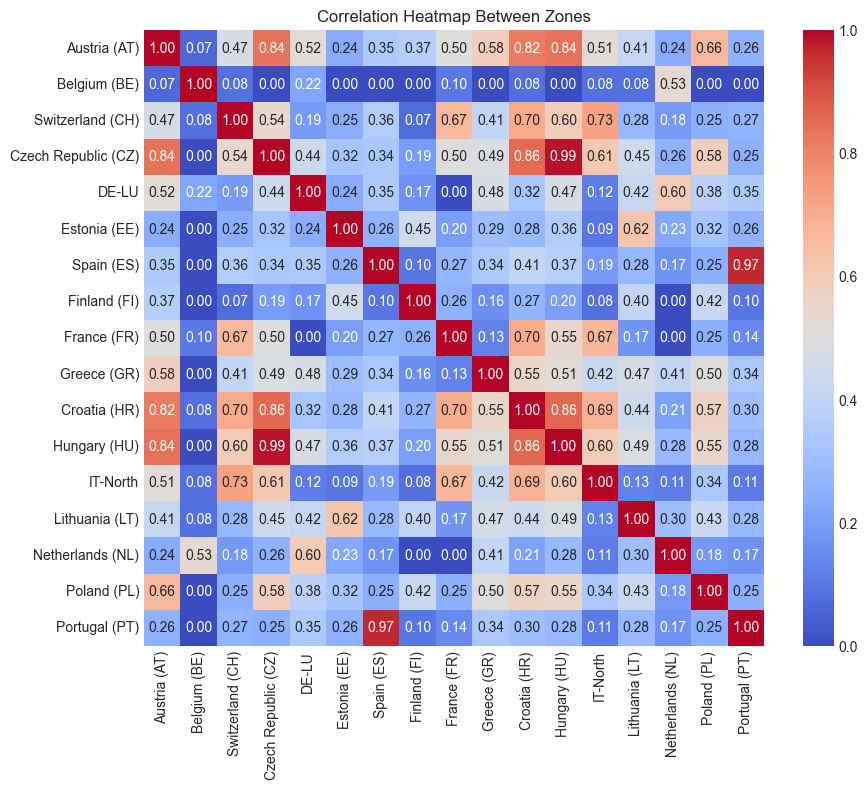

In [54]:

plt.figure(figsize=(10, 8))
sns.heatmap(EDC_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm")
plt.title(f"Correlation Heatmap Between Zones")
plt.show()
    


In [39]:
#Rolling window EDC
# define network density 
def network_density(EDC_matrix):
    """
    Calculate the network density of a correlation matrix.
    
    Parameters:
    ---------------
    EDC_matrix (DataFrame): The correlation matrix.
    
    Returns:
    --------
    float: The network density.
    """
    n = len(EDC_matrix)
    num_edges = np.sum(np.abs(EDC_matrix.values))  # Count edges with absolute value > 0.5
    return num_edges / (n * (n - 1))  # Maximum number of edges in a complete graph


In [40]:
network_density(EDC_matrix)

0.34119860729547896

In [49]:
def rolling_EDC_matrices(df, zone_list, window_size=365, alpha=0.9):
    """
    Compute rolling EDC matrices over a given window size.

    Parameters:
    ------------
    df (DataFrame): DataFrame with 'date' column and zone return columns.
    zone_list (list): List of zone column names.
    window_size (int): Rolling window size (default=250).
    alpha (float): Confidence level for CVaR (default=0.975).

    Returns:
    --------
    matrices (list): List of DataFrames (EDC matrices).
    dates (list): Corresponding end dates for each rolling window.
    """
    df = df.copy()
    df["DateTime(UTC)"] = pd.to_datetime(df["DateTime(UTC)"])

    #create a rolling range
    rolling_dates = pd.Series(df["DateTime(UTC)"].unique()).sort_values().reset_index(drop=True)

    matrices = []
    dates = []

# Rolling window loop
    for i in range(len(rolling_dates) - window_size + 1):
        start_date = rolling_dates[i]
        end_date = rolling_dates[i + window_size - 1]
        window_df = df[(df["DateTime(UTC)"] >= start_date) & (df["DateTime(UTC)"] <= end_date)]
        #build the EDC matrix for the current window

        edc_mat= build_EDC_matrix_symmetric(zone_list=zone_list, df=window_df, start_year=start_date.year, 
                                            end_year=end_date.year,start_month=start_date.month, 
                                            start_day=start_date.day, end_month=end_date.month, end_day=end_date.day, 
                                            alpha=alpha)
        matrices.append(edc_mat)
        dates.append(start_date)

    return matrices, dates

In [50]:
# Create a DataFrame with the date and log_yields for each zone
matrici_edc, date_edc = rolling_EDC_matrices(df_log_yields, countries, window_size=365, alpha=0.99)

In [ ]:
#apply network density function to the list of matrices
network_density_list = [network_density(mat) for mat in matrici_edc]
#network_density_list

[0.2013510061945622,
 0.20135190906301756,
 0.20135223224239188,
 0.20135220267087797,
 0.20135240617012257,
 0.20135331434747816,
 0.20135243615096377,
 0.2013530395742769,
 0.20135333224463037,
 0.20135310237710488,
 0.20135397139117922,
 0.20135276598699073,
 0.20135252511073332,
 0.21068126301015438,
 0.2106812136760862,
 0.21068092585779893,
 0.21067689520309074,
 0.19533625606623103,
 0.19533708283423182,
 0.1953383012196814,
 0.1953363274686995,
 0.19533788451435355,
 0.19533794316156097,
 0.1953363299183788,
 0.19533637944102467,
 0.19533576710062728,
 0.1953365414637938,
 0.19534070615164847,
 0.195336741393989,
 0.19533926388143893,
 0.19533826950813513,
 0.19533670269418374,
 0.19532582763517703,
 0.19532610370670025,
 0.19532622062392752,
 0.18603628201552183,
 0.18603524260761967,
 0.18603497005899808,
 0.18603712904369357,
 0.18603661105239178,
 0.18603867789516162,
 0.18603948411692114,
 0.18603764992482646,
 0.18603462204939034,
 0.18603231299663514,
 0.1860355910296870

Text(0.5, 1.0, 'Network Density Over Time')

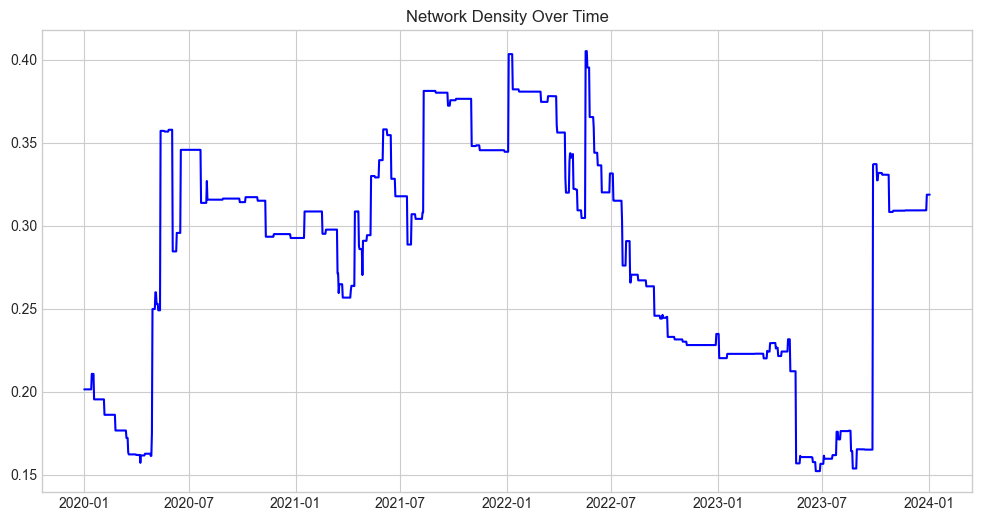

In [52]:
#plot nerwork density during the time 
plt.figure(figsize=(12, 6))
plt.plot(date_edc, network_density_list, linestyle='-', color='b')
plt.title("Network Density Over Time")